In [1]:
# HIDDEN
from datascience import *
from prob140 import *
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import math
from scipy import stats
from scipy import special
from itertools import permutations

In [2]:
# HIDDEN
# The alphabet
alph = make_array('a', 'd', 't')

In [3]:
# HIDDEN
# Decode atdt using all possible decoders
x1 = [['a', 't', 'd', 't'], ['a','d','t','d'], ['d','t','a','t']]
x2 = [['d','a','t','a'], ['t','d','a','d'], ['t','a','d','a']]
decoded = x1+x2

In [4]:
# HIDDEN
decoding = Table().with_columns(
    'Decoder', list(permutations(alph)),
    'atdt Decoded', decoded
)

In [5]:
# HIDDEN
# Make bigram transition matrix
# Data from Peter Norvig's bigram table

aa = 1913489177
dd = 6513992572
tt = 19222971337
ad = 23202347740
da = 23279747379
at = 80609883139
ta = 42344542093
dt = 10976756096
td = 3231292348

row1 = make_array(aa, ad, at)/sum([aa, ad, at])
row2 = make_array(da, dd, dt)/sum([da, dd, dt])
row3 = make_array(ta, td, tt)/sum([ta, td, tt])
rows = np.append(np.append(row1, row2), row3)


In [6]:
# HIDDEN
bigrams = MarkovChain.from_table(Table().states(alph).transition_probability(rows))

## Code Breaking ##

We can use Markov chains that have detailed balance to solve a class of problems that are intractable by other methods and are apparently unrelated to Markov chains. In this section we present an example of how such problems arise. In the next section we discuss a solution.

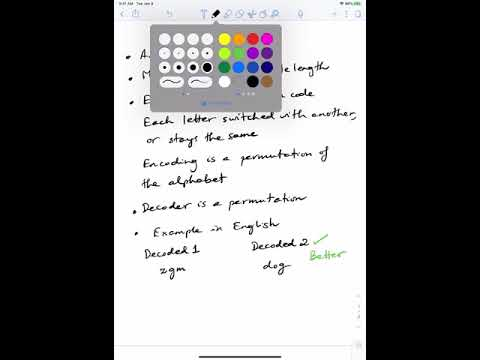

In [7]:
# VIDEO: Assumptions
from IPython.display import YouTubeVideo

YouTubeVideo('C18hs5sHf0Y')

### Assumptions ###
People have long been fascinated by encryption and decryption, well before cybersecurity became part of our lives. Decoding encrypted information can be complex and computation intensive. Reversed Markov Chains can help us in this task.

To get a sense of one approach to solving such problems, and of the extent of the task, let's try to decode a short piece of text that has been encoded using a simple code called a *substitution code*. Text is written in an *alphabet*, which you can think of as a set of letters and punctuation. In a substitution code, each letter of the alphabet is simply replaced by another in such a way that the code is just a permutation of the alphabet.

To decode a message encrypted by a substitution code, you have to *invert* the permutation that was used. In other words, you have to apply a permutation to the *coded* message in order to recover the original text. We will call this permutation the *decoder*.

To decode a textual message, we have to make some assumptions. For example, it helps to know the language in which the message was written, and what combinations of letters are common in that language. For example, suppose we try to decode a message that was written in English and then encrypted. If our decoding process ends up with "words" like zzxtf and tbgdgaa, we might want to try a different way.

So we need data about which sequences of letters are common. Such data are now increasingly easy to gather; see for example this [web page](http://norvig.com/ngrams/) by [Peter Norvig](http://norvig.com), a Director of Research at Google. 

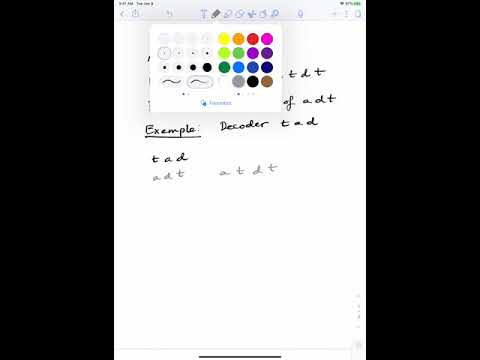

In [8]:
# VIDEO: Decoders

YouTubeVideo('MUdZWq3b0mg')

### Decoding a Message ###
Let's see how we can use such an approach to decode a message. For simplicity, suppose our alphabet consists of only three letters: a, d, and t. Now suppose we get the coded message atdt. We believe it's an English word. How can we go about decoding it in a manner that can be replicated by a computer for other words too?

As a first step, we will write down all 3! = 6 possible permutations of the letters in the alphabet and use each one to decode the message. The table `decoding` contains all the results. Each entry in the `Decoder` column is a permutation that we will apply to our coded text atdt. The permutation determines which letters we will use as substitutes in our decoding process. 

To see how to do this, start by keeping the alphabet in "alphabetical" order in your head: 'a', 'd', 't'. Now look at the rows of the table.

- The decoder in the first row is ['a', 'd', 't']. This decoder simply leaves the letters unchanged; atdt gets decoded as atdt. 

$$
\text{Decoder ['a', 'd', 't']: } ~~~ a \to a, ~~~ d \to d, ~~~ t \to t
$$

- The decoder in the second row is ['a', 't', 'd']. This keeps the first letter of the alphabet 'a' unchanged, but replaces the second letter 'd' by 't' and the third letter 't' by 'd'.

$$
\text{Decoder ['a', 't', 'd']: } ~~~ a \to a, ~~~ d \to t, ~~~ t \to d
$$

So atdt gets decoded as adtd.

You can read the rest of the table in the same way. 

Notice that in each decoded message, a letter appears twice, at indices 1 and 3. That's the letter being used to decode t in atdt. A feature of substitution codes is that each letter *original* is coded by a letter *code*, with the same letter *code* being used every time the letter *original* appears in the text. So the decoder must have the same feature.

In [9]:
decoding

Decoder,atdt Decoded
['a' 'd' 't'],['a' 't' 'd' 't']
['a' 't' 'd'],['a' 'd' 't' 'd']
['d' 'a' 't'],['d' 't' 'a' 't']
['d' 't' 'a'],['d' 'a' 't' 'a']
['t' 'a' 'd'],['t' 'd' 'a' 'd']
['t' 'd' 'a'],['t' 'a' 'd' 'a']


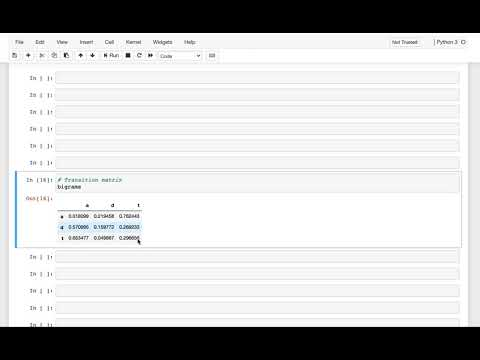

In [10]:
# VIDEO: Bigrams

YouTubeVideo('OrLjMVjpryY')

Which one of these decoders should we use? To make this decision, we have to know something about the frequency of letter transitions in English. Our goal will be to pick the decoder according to the frequency of the decoded word.

We have put together some data on the frequency of the different *bigrams*, or two-letter combinations, in English. Here is a transition matrix called `bigrams` that is a gross simplification of available information about bigrams in English; we used Peter Norvig's bigrams table and restricted it to our three-letter alphabet. The row corresponding to the letter 'a' assumes that about 2% of the bigrams that start with 'a' are 'aa', about 22% are 'ad', and the remaining 76% are 'at'. 

It makes sense that the 'aa' transitions are rare; we don't use words like aardvark very often. Even 2% seems large until you remember that it is the proportion of 'aa' transitions only among transitions 'aa', 'ad', and 'at', because we have restricted the alphabet. If you look at its proportion among all $26\times26$ bigrams, that will be much lower.

In [11]:
bigrams

,a,d,t
a,0.018099,0.219458,0.762443
d,0.570995,0.159772,0.269233
t,0.653477,0.049867,0.296656


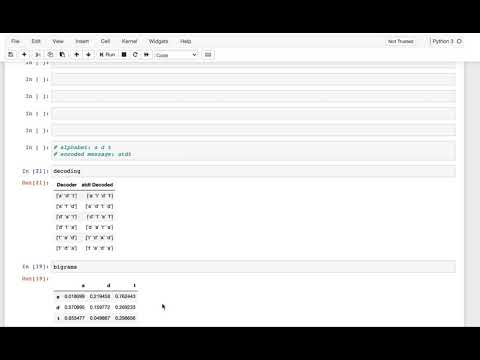

In [12]:
# VIDEO: Score of a Decoder

YouTubeVideo('pi36R1lN8ww')

Now think of the true text as a path of a Markov Chain that has this transition matrix. An interesting historical note is that this is what Markov did when he first came up with the process that now bears his name – he analyzed the transitions between vowels and consonants in *Eugene Onegin*, Alexander Pushkin's novel written in verse.

According to our `decoding` table above, tada is the result we get by applying the decoder ['t', 'd', 'a'] to our data atdt. It makes sense to consider this decoder to be a good decoder if the decoded text tada is likely to appear in our language. 

To quantify this idea, remember that if the true text is tada, then we can think of the sequence tada as the path of a Markov chain. Let's define the *score* of the decoder ['t', 'd', 'a'] to be the probability of the path tada given the starting point. So the score is $P(t, a)P(a, d)P(d, a)$. Later we will introduce more formal calculations and terminology to go deeper into this choice.

In the same way, we can give each decoder a score based on the probability of its decoded text. Higher scores correspond to better decoders.

In [13]:
# score of decoder ['t', 'd', 'a']
0.653477 * 0.219458 * 0.570995

0.08188682431730866

To automate such calcuations we can use the `prob_of_path` method. Remember that its first argument is the initial state, and the second argument is a list or array consisting of the remaining states in sequence.

In [14]:
bigrams.prob_of_path('t', ['a', 'd', 'a'])

0.08188681629194244

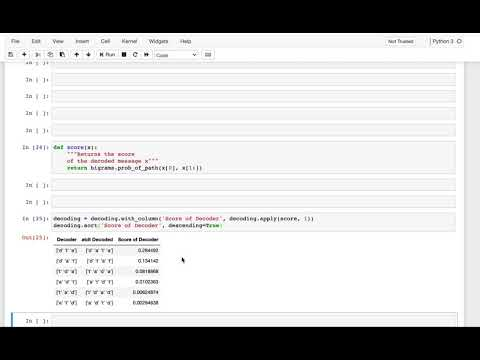

In [15]:
# VIDEO: The Best Decoder

YouTubeVideo('zCAeQUaPf1E')

Should we decide that our message atdt should be decoded as tada? Perhaps, if we think that 8% is a high likelihood. But what if some other possible decoder has a higher likelihood? In that case it would be natural to prefer that one.

So we are going to need the probabilities of each of the six "decoded" paths.

Let's define a function `score` that will take a list or array of characters and return the probability of the corresponding path using the `bigrams` transition matrix. In our example, this is the same as returning the score of the corresponding decoder.

In [16]:
def score(x):
    return bigrams.prob_of_path(x[0], x[1:])

Here are the results in decreasing order of score. There is a clear winner: the decoder ['d', 't', 'a'] corresponding to the message 'data' has more than twice the score of any other decoder.

In [17]:
decoding = decoding.with_column('Score of Decoder', decoding.apply(score, 1))
decoding.sort('Score of Decoder', descending=True)

Decoder,atdt Decoded,Score of Decoder
['d' 't' 'a'],['d' 'a' 't' 'a'],0.284492
['d' 'a' 't'],['d' 't' 'a' 't'],0.134142
['t' 'd' 'a'],['t' 'a' 'd' 'a'],0.0818868
['a' 'd' 't'],['a' 't' 'd' 't'],0.0102363
['t' 'a' 'd'],['t' 'd' 'a' 'd'],0.00624874
['a' 't' 'd'],['a' 'd' 't' 'd'],0.00294638


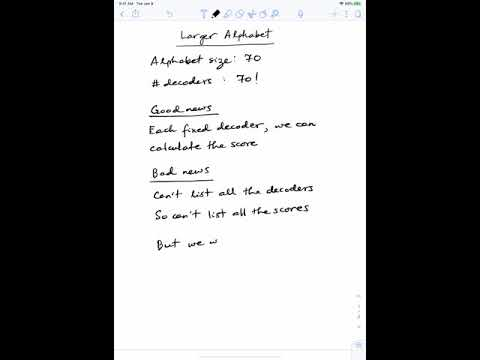

In [18]:
# VIDEO: Larger Alphabet

YouTubeVideo('XLd2MuMIlR4')

### The Size of the Problem ###
What we have been able to do with an alphabet of three characters becomes daunting when the alphabet is larger. The 52 lower case and upper case letters, along with a space character and all the punctuations, form an alphabet of around 70 characters. That gives us 70! different decoders to consider. In theory, we have to find the likelihood of each of these 70! candidates and sort them.

Here is the number 70!. That's a lot of decoders. Our computing system can't handle that many, and other systems will have the same problem.

In [19]:
int(special.factorial(70))

11978571669969890269925854460558840225267029209529303278944419871214396524861374498691473966836482048

One potential solution is to sample at random from these 70! possible decoders and just pick from among the sampled permutations. But how should we draw from 70! items? 

It's not a good idea to choose uniform random permutations of the alphabet, as those are unlikely to get us quickly to the desired solution. 

What we really want our sampling procedure to do is to choose *good* decoders with high probability. A good decoder is one that generates text that has higher probability in our language than text produced by almost all other decoders. In other words, a good decoder is one that has a high score.

Even when the alphabet is large, for any particular decoder $j$ we can find its score by multiplying transition probabilities sequentially, as we did in our small example. But we can't list all the decoders because there are too many of them. So we can't list all the scores.

So it seems we have a problem.

- For an individual decoder, we can calculate the score.
- We want to find the decoder that has the highest score.
- We can't list all the decoders (and their scores) because there are too many of them.

This seems like an impossible situation: we have to find the mode of a function we can't write down. But as you will see in the next section, detailed balance comes to the rescue.

**Technical Note**

Formally, a good decoder has higher likelihood than other decoders, given the data.

You can write down this likelihood using Bayes' Rule. Let $S$ represent the space of all possible permutations; if the alphabet has $N$ characters, then $S$ has $N!$ elements. For any randomly picked permutation $j$, the likelihood of that decoder given the data is:

$$
\begin{align*}
\text{Likelihood of decoder } j \text{ given the encoded text}
&= \frac{\frac{1}{N!} P(\text{encoded text} \mid \text{decoder = }j)}
{ {\sum_{i \in S} } \frac{1}{N!} P(\text{encoded text} \mid \text{decoder = }i)} \\ \\
&=\frac{P(\text{encoded text} \mid \text{decoder = }j)}
{ {\sum_{i \in S} } P(\text{encoded text} \mid \text{decoder = }i)}
\end{align*}
$$

For the given encoded text, the denominator is the normalizing constant that makes all the likelihoods sum to 1. It appears in the likelihood of every decoder. So it's not necessary for comparing two likelihoods. In our example with the three-letter alphabet, we ignored it because we could figure out the numerators for all six decoders and just compare them. 

The numerator is what we have been calling the *score* of the decoder. For any particular decoder, we can find that.

But with a large alphabet we can't do this for all possible decoders, so we can't list all possible scores and we can't add them all up. Therefore we don't know the denominator of the likelihoods, not even up to a decent approximation.

What we need now is a method that helps us draw from a probability distribution even when we don't know the normalizing constant. That is what Markov Chain Monte Carlo helps us to do.